# 4. 이미지 어디까지 우려볼까  


## 4-1. 들어가며

augmentation기법을 적용해 ResNet-50을 학습시켜보자.  
텐서플로우의 랜덤 augmentation API를 사용해보고, 최신 augmentation 기법을 익힌 뒤, 훈련 데이터셋의 augmentation적용에 따른 모델 성능변화를 비교해보자.  


### 실습목표
---------------------------------------------------------------------------------------
  1. Augmentation을 모델 학습에 적용하기
  2. Augmentation의 적용을 통한 학습 효과 확인하기
  3. 최신 data augmentation 기법 구현 및 활용하기  
  
  
### 학습 내용
---------------------------------------------------------------------------------------
  1. Augmentation 적용 (1) 데이터 불러오기
  2. Augmentation 적용 (2) Augmentation 적용하기
  3. Augmentation 적용 (3) 비교 실험하기
  4. 심화기법 (1) Cutmiz Augmentation
  5. 심화기법 (2) Mixup Augmentation
  6. 프로젝트: CutMix 또는 Mixup 비교실험하기
  
  
### 준비물
--------------------------------------------------------------------------------
터미널을 통해 디렉토리 생성
```
$ mkdir -p ~/aiffel/data_augmentation/data
```

## 4-2. Augmentation 적용 (1) 데이터 불러오기
augmentation을 텐서플로우 모델 학습에 어떻게 적용할 수 있는지 공부해보자. 지금까지 모델 훈련전에 데이터를 전처리하고 입력값으로 사용해왔는데, augmentation도 입력이미지의 데이터를 변경하는 것이므로 이미지데이터 전처리방법과 사용법이 동일합니다.  


```
$ pip install tensorflow_datasets
```

In [1]:
!pip install tensorflow_datasets

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

이번에는 stanford_dogs 데이터셋을 사용합니다.  
120종류의 개 사진이 있으며 학습셋이 12,000장, 평가셋이 8,580장으로 총 20,580장입니다.  
데이터셋은 TensorFlow Datasets 디렉토리에 저장됩니다.  

In [4]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

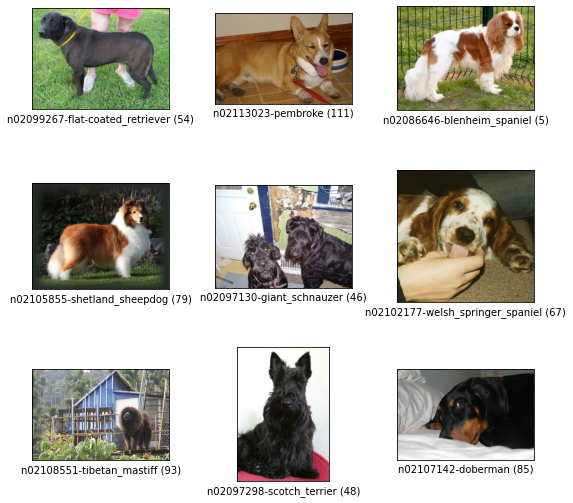

In [5]:
fig = tfds.show_examples(ds_train, ds_info)

## 4-3. Augmentation 적용 (2) Augmentation 적용하기  


### 텐서플로우 Random Augmentation API 사용하기
---------------------------------------------------------
아래는 텐서플로우 API로 적용가능한 random확률로 적용가능한 augmentation함수.  
  * random_brightness()
  * random_contrast()
  * random_crop()
  * random_flip_left_right()
  * random_flip_up_down()
  * random_hue()
  * random_jpeg_quality()
  * random_saturation()  
  
augmentation적용하기전에 전처리함수(정규화, 사이즈조절)를 만들자.  

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

이미지 변환 전처리함수는 아래와 같은 형태를 가진다.  
```
def 전처리_함수(image, label):   # 변환할 이미지와 
    # 이미지 변환 로직 적용
    new_image = 이미지_변환(image)
    return new_image, label
```
위와 같이 설정하면 변환한 이미지를 다음 전처리함수에 넣을 수 있습니다.  

위에서 언급한 random_left_right(), random_brightness()를 활용해보겠습니다.
테스트 데이터셋에 상하반전이 된 개 이미지는 없을 것이기에 좌우반전으로 늘린 데이터만 의미가 있을 것입니다.  
또한 밝기를 조절하면 다양한 환경에서 얻어진 이미지를 만들 수 있습니다.

In [7]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

오늘은 augmentation을 통해 다양한 형태로 새로운 데이터셋을 얻는 과정을 구현한 함수를 apply_normalize_on_dataset()으로 정의.  
우리는 apply_normalize_on_dataset()을 통해 일반적인 전처리(normalize, resize, augmentation, shuffle)을 적용.  
주의할 점은 shuffle이나 augmentation은 테스트 데이터셋에 적용하지 않는다.  
앙상블(ensemble)기법 중에 테스트 데이터셋에 augmentation을 적용하는 test-time augmentation방법 존재.  
캐글같은 경쟁 머신러닝에서 많이 사용하지만, 지금은 개념만 알고 있자.  
자세한 설명은 [여기](https://hwiyong.tistory.com/215)서 확인  

수행할 비교실험을 위해서 with_aug 매개변수를 통해 augmentation 적용여부 결정.  
[map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)

In [8]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### Random Augmentation 직접 구현하기
-----------------------------------------------
위에서는 미리 구현된 random augmentation을 적용해서 augment()함수 작성.  
이번에는 tf.image 함수를 사용해서 다양한 augmentation기법을 적용한 augment2()를 작성해보자.  
[tf.image](https://www.tensorflow.org/api_docs/python/tf/image)  

In [9]:
# make random augment function
def augment2(image,label):
  image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00)) # 50%의 확률로 이미지 가운데 부분을 crop합니다.
  image = tf.image.resize(image, INPUT_SHAPE) # crop한 이미지를 원본 사이즈로 resize
  return image, label

## 4-4. Augmentation 적용 (3) 비교실험하기  
우리가 비교할 것은 augmentation을 적용한 데이터를 학습시킨 모델과 적용하지 않은 데이터를 학습시킨 모델의 성능.  
아래코드는 텐서플로우 케라스의 ResNet50 중 Imagenet에 훈련된 모델을 불러온다.  
include_top은 마지막 fully connected layer를 포함할지 결정한다.  
해당 레이어를 포함하지 않고 생성하면 특성추출기(feature extractor)부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 사용할 수 있다. 우리의 테스트셋과 이미지넷과 다른 클래스를 갖기에 fully connected layer의 구조도 달라야 한다.

In [10]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

Augmentation을 적용한 데이터셋으로 학습할 ResNet하나 더 생성

In [11]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

apply_normalize_on_dataset()에서 with_aug를 False로 주면 augmentation이 적용되지 않도록 해놨기에 하나는 False, 하나는 True로 해줘야 한다.

In [12]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

이제 두 모델 둘다 학습시키고 검증을 진행한다.  
아래 학습은 원래 epoch=20으로 3~4시간정도 학습을 해야 augmentation효과를 명확히 검증할 수 있지만, 진행을 위해서 3번만 돌린다.  
실제 프로젝트에서는 충분한 학습을 진행해야 한다.

In [13]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 3

tf.random.set_seed(2020)
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3
750/750 [==============================] - 125s 166ms/step - loss: 2.2121 - accuracy: 0.4515 - val_loss: 3.3641 - val_accuracy: 0.2185
Epoch 2/3
750/750 [==============================] - 120s 160ms/step - loss: 0.7629 - accuracy: 0.7855 - val_loss: 1.1487 - val_accuracy: 0.6643
Epoch 3/3
750/750 [==============================] - 123s 164ms/step - loss: 0.2583 - accuracy: 0.9430 - val_loss: 0.9552 - val_accuracy: 0.7184
Epoch 1/3
  2/750 [..............................] - ETA: 1:35 - loss: 5.2164 - accuracy: 0.0312WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0640s vs `on_train_batch_end` time: 0.0974s). Check your callbacks.


750/750 [==============================] - 126s 168ms/step - loss: 2.2333 - accuracy: 0.4358 - val_loss: 2.9770 - val_accuracy: 0.2674
Epoch 2/3
750/750 [==============================] - 125s 166ms/step - loss: 0.9359 - accuracy: 0.7278 - val_loss: 1.1670 - val_accuracy: 0.6596
Epoch 3/3
750/750 [==============================] - 126s 168ms/step - loss: 0.5139 - accuracy: 0.8559 - val_loss: 1.0661 - val_accuracy: 0.6938


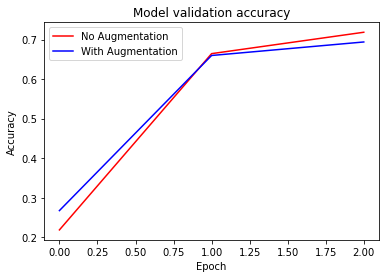

In [14]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

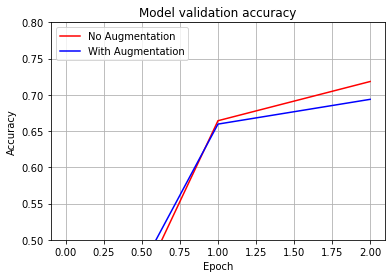

In [15]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

epoch=20으로 진행하면 아래와 같다. augmentation을 적용한 경우가 더 천천히 학습하지만, epoch 10을 전후로 aug_resnet50의 accuracy가 높아짐을 알 수 있다.
<img src="compare.png">

## 4-5. 심화기법 (1) Cutmix Augmentation  
좀더 복잡한 CutMix augmentation에 대해서 알아보자.  
[CutMix논문](https://arxiv.org/pdf/1905.04899.pdf)  
[CutMix_Kaggle](https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu)  
CutMix는 네이버 클로바에서 발표한 위의 논문에서 제안한 방법으로 이름에서 알 수 있듯이 이미지데이터를 자르고 섞는 방법.  


아래 ResNet-50은 우리가 일반적으로 사용하는 방식이고, Mixup은 특정비율로 픽셀별 값을 섞는 방식. Cutout은 이미지를 자르는 방식이고, CutMix는 Mixup과 비슷하지만 일정영역을 잘라서 붙이는 방식.  
두번째 링크에서 캐글 그랜드마스터가 구현한 CutMix와 Mixup을 확인할 수 있다. 남은 스텝에서 CutMix와 Mixup을 구현할 때 참고하자.

CutMix는 이미지를 섞는 부분과 섞은 이미지에 맞춰서 라벨을 섞는 부분을 포함한다.  
<img src="CutMix.png">

### 1) 이미지 섞기
-------------------------------------------------------------------------------
두개의 이미지를 섞어주는 것부터 구현. 배치내의 이미지 2개를 골라 섞어준다.  
이때 이미지내에서 잘라서 섞어주는 영역을 바운딩 박스라고 부른다.  
훈련 데이터셋에서 이미지 2개를 가져오자.
아래 코드블록에서 바운딩 박스의 위치를 랜덤하고 뽑고, 이를 잘라내서 두개의 이미지를 섞어주는 함수를 만들어보자.  
이미지를 텐서로 만들어 텐서플로우 연산을 사용해보자. 이때 이미지는 tfds에서 한장 뽑아서 사용하자.  

In [16]:
print(ds_train_no_aug.take(1))

<TakeDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


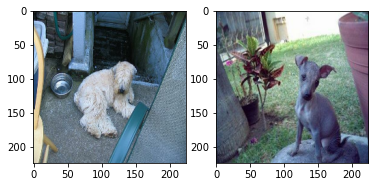

In [17]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

2개의 이미지를 얻었으니 첫번째 이미지를 바탕이미지로 쓰고, 두번째 이미지를 삽입하기로 하자.  
이때 a영역에서 삽입될 영역의 바운딩 박스위치를 결정하는 함수를 구현하자  
이번 데이터셋은 이미지들의 사이즈가 비슷하지만, CutMix의 공식 repo는 이미지 크기와 상관없이 가변 적용이 가능하도록 구현되어 있기에, 임의의 사이즈에도 대응하도록 구현하자.

In [18]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(65, shape=(), dtype=int32) tf.Tensor(88, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


바탕이미지a에서는 바운딩 박스 바깥부분을, 삽입할 이미지b에서는 바운딩 박스 안쪽 영역을 가져와서 합치는 함수 구현하자.

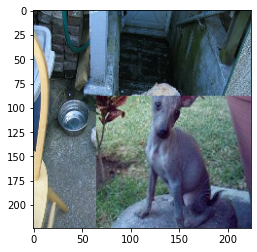

In [19]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

### 2) 라벨 섞기
-----------------------------------------------------------------
이미지를 섞었으니 라벨도 이에 맞게 섞어줘야 한다.  
CutMix에서는 면적에 비례해서 라벨을 섞어준다.  
a,b를 섞을 때, a를 0.4만큼 섞으면 A의 클래스를 0.4만큼, B의 클래스를 0.6만큼 가지도록 한다. 원핫코딩방식이 아니라 A, B 클래스에 해당하는 인덱스에 0.4, 0.6만큼씩 배분. 아래에는 비율에 맞게 라벨을 합쳐주는 함수

In [20]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.56903696, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

위에서 2가지 구현한 함수를 활용해 cutmix()함수를 구현해보자

In [52]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.concat(mixed_labels),(batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

## 4-6. 심화 기법(2) Mixup Augmentation  
[mixup논문](https://arxiv.org/abs/1710.09412)  
Mixup은 CutMix보다 간단하게 이미지와 라벨을 섞어준다.  
두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단하다.  
이미지를 섞을 비율을 일정한 범위내에서 랜덤하고 뽑고, 비율값에 따라 이미지의 픽셀별 값과 라벨을 섞어준다.  
<img src="Mixup.png">  

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.56903696 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

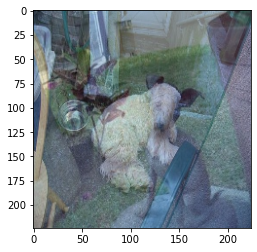

In [22]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

배치 단위 mixup()함수 구현

In [23]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 4-7. 프로젝트: CutMix 또는 Mixup 비교실험 하기  
이번에는 최신기법(CutMix, Mixup)을 적용해서 모델을 훈련시키고, 데이터 셋에 둘중 하나만 적용해서 모델을 학습시켜주세요. 결과를 수치화하고 비교해보세요.  

### 1. Augmentation을 적용한 데이터셋 만들기
---------------------------------------------------------------------
데이터셋에 CutMix 또는 Mixup augmentation을 적용해주세요.  
Q1. 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다. batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?  
Ans) CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.

In [33]:
def onehot(image,label):
    CLASSES = ds_info.features["label"].num_classes
    return image,tf.one_hot(label,CLASSES)

In [34]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug: # test가 아니고 aug적용
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix: # test가 아니고 cutmix적용
        #ds = ds.batch(batch_size)
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:  #테스트가 아니고 아무것도 적용X, 테스트
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test: # test가 아니면 
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 2. 모델 만들기
------------------------------------------------------------------------------------
앞서 만들었던 것처럼 비교실험을 위한 모델 두 개를 만들어주세요. 모델은 ResNet-50을 사용합시다.  

In [35]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, #include_top은 마지막 fully connected layer를 포함할지 안할지 결정
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [36]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [53]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=False)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_cutmix_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_no_cutmix_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True, with_cutmix=False)

ValueError: in user code:

    <ipython-input-52-e4d887ee5fe3>:14 cutmix  *
        mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    /home/ssac19/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /home/ssac19/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:195 reshape
        result = gen_array_ops.reshape(tensor, shape, name)
    /home/ssac19/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py:8234 reshape
        "Reshape", tensor=tensor, shape=shape, name=name)
    /home/ssac19/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /home/ssac19/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:593 _create_op_internal
        compute_device)
    /home/ssac19/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3485 _create_op_internal
        op_def=op_def)
    /home/ssac19/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1975 __init__
        control_input_ops, op_def)
    /home/ssac19/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Cannot reshape a tensor with 0 elements to shape [16,224,224,3] (2408448 elements) for '{{node Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](stack, Reshape/shape)' with input shapes: [0], [4] and with input tensors computed as partial shapes: input[1] = [16,224,224,3].


### 3. 모델 훈련하기
--------------------------------------------------------
모델을 훈련시켜 주세요.  

힌트: 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해주세요!  
Q3. sparse_categorical_crossentropy()를 사용하지 못하는 이유가 뭘까요?  
Ans) 우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문

In [ ]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 3

tf.random.set_seed(2020)
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_cutmix = resnet50.fit(
    ds_train_no_cutmix, # cutmix 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

### 4. 훈련 과정 시각화하기
-------------------------------------------------------------
훈련과정의 히스토리를 그래프로 시각화해주세요.  

In [ ]:
plt.plot(history_resnet50_no_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug, CutMix', 'No Aug, With CutMix'], loc='upper left')
plt.show()

### 5. Augmentation에 의한 모델 성능 비교  
-------------------------------------------------------------------------  
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요